## Librerías

In [14]:
import rasterio
import rasterstats

import earthpy.plot as ep
from os import listdir, path
from datetime import datetime, date


import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator

import numpy as np
import pandas as pd
import geopandas as gpd

import datetime


In [19]:
parcelas = gpd.read_file(r"C:\Users\DELL\PycharmProjects\Tesis\Poligonos\SHP\Rancho_SantaAnita\Lote_Rancho_Santa_Anita.shp")

parcelas_wgs = parcelas.to_crs(4326)

In [13]:
agera_path = r"C:\Users\DELL\Documents\Tesis_sugarCane\pruebas"

In [15]:
et_images = {}


for i in listdir(agera_path):
    if i.endswith('.tif'):
        full_path = path.join(agera_path, i)
        path_parts = full_path.split('_')
        last_part = path_parts[-1]
        fecha, extension = tuple(last_part.split('.'))
        year, month, day = int(fecha[0:4]), int(fecha[4:6]), int(fecha[6:8])
        fecha_final = date(year, month, day)
        
        et_images[fecha_final] = full_path

In [20]:
stats_eva = {}

parcelas_wgs['geometry'] = parcelas_wgs['geometry'].centroid

for fecha, image_path in et_images.items():
    #image_str = str(image)
    #fecha = f'{image_str[16:20]}-{image_str[20:22]}-{image_str[22:24]}'
    src = rasterio.open(image_path)
    et = src.read(1)
    #earthpy.plot.plot_bands(et)
    transform = src.transform
    
    pixel_values = []
    
    for geom in parcelas_wgs['geometry']:
        x, y = geom.x, geom.y
        row, col = src.index(x, y)
        pixel_val = src.read(1, window=((row, row+1), (col, col+1)))
        pixel_values.append(pixel_val[0][0])
        
    stats_eva[fecha] = {'Imagen': image_path, 'Pixel_values': pixel_values}

C:\Users\DELL\AppData\Local\Temp\ipykernel_3204\2709913156.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parcelas_wgs['geometry'] = parcelas_wgs['geometry'].centroid


In [21]:
fechas = []
imagenes = []
columnas_pixel = {}

for fecha, valores in stats_eva.items():
    fechas.append(fecha)
    imagenes.append(valores['Imagen'])
    for i, valor in enumerate(valores['Pixel_values']):
        if i not in columnas_pixel:
            columnas_pixel[i] = []
        columnas_pixel[i].append(valor)

# Crear el DataFrame
df = pd.DataFrame({'Fecha': fechas, 'Imagen': imagenes, **columnas_pixel})

# Mostrar el DataFrame
df

,Fecha,Imagen,0,1,2,3,4,5,6
0,2021-01-01,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,1.972649,1.972649,1.972649,1.972649,1.972649,1.972649,1.972649
1,2021-01-02,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,2.167568,2.167568,2.167568,2.167568,2.167568,2.167568,2.167568
2,2021-01-03,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,2.721180,2.721180,2.721180,2.721180,2.721180,2.721180,2.721180
3,2021-01-04,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,2.894043,2.894043,2.894043,2.894043,2.894043,2.894043,2.894043
4,2021-01-05,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,2.901426,2.901426,2.901426,2.901426,2.901426,2.901426,2.901426
...,...,...,...,...,...,...,...,...,...
809,2023-03-21,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,5.143841,5.143841,5.143841,5.143841,5.143841,5.143841,5.143841
810,2023-03-22,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.972660,4.972660,4.972660,4.972660,4.972660,4.972660,4.972660
811,2023-03-23,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,4.922693,4.922693,4.922693,4.922693,4.922693,4.922693,4.922693
812,2023-03-24,C:\Users\DELL\Documents\Tesis_sugarCane\prueba...,5.721313,5.721313,5.721313,5.721313,5.721313,5.721313,5.721313


In [22]:
df['acum_parcela0'] = df[0].cumsum()

In [23]:
def plot_data(data, columns: list, title):
    
    fig, ax = plt.subplots(figsize=(14, 7))
    plt.style.use('_mpl-gallery')
    
    #ax.xaxis.set_major_locator(MonthLocator(interval=1))
    #ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
    ax.yaxis.grid(True, zorder=0)
    
    ax.set_title(title)
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Evapotranspiración de referencia $mm día^{-1}$')
    
    ax.plot(data[columns[0]], data[columns[1]], linewidth=1)
    #ax.scatter(data[columns[0]], data[columns[1]], linewidth=1.0, color='red')
    
    plt.xticks(rotation=90)
    plt.show()

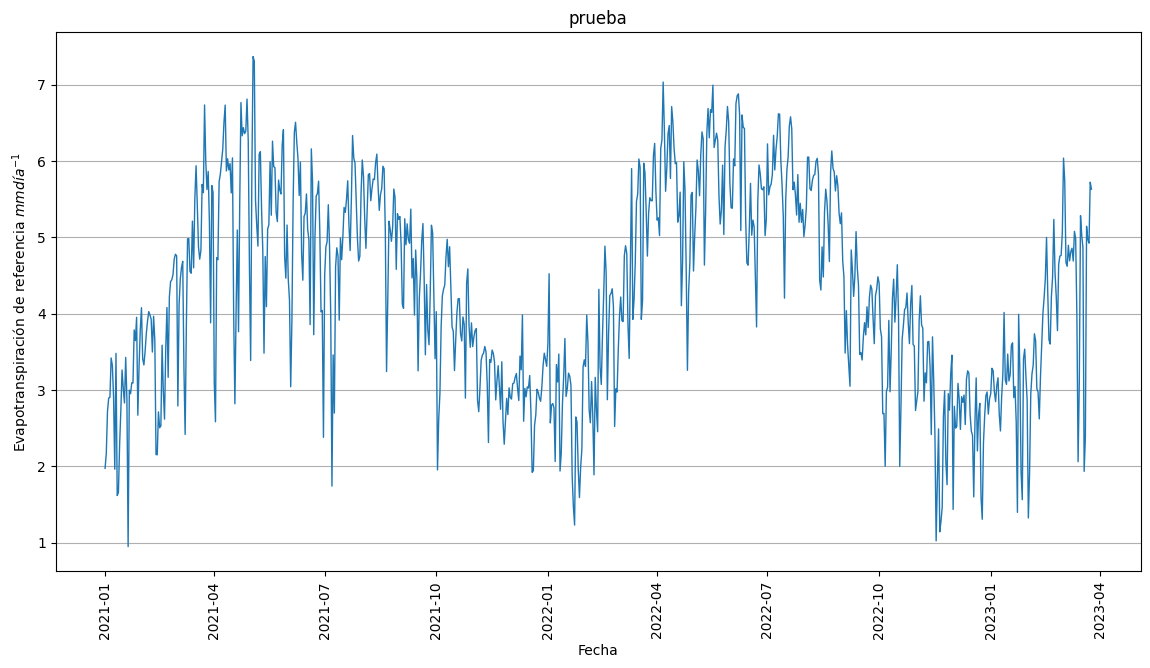

In [24]:
plot_data(df, columns=['Fecha', 0], title='prueba')

## Hasta aquí la parte de ET

In [28]:
def ndvi(image):
    nir = image.read(4)
    red = image.read(3)

    nir_dtype = nir.astype('float64')
    red_dtype = red.astype('float64')

    ndvi_calc = (nir_dtype - red_dtype) / (nir_dtype + red_dtype)

    return ndvi_calc

In [29]:
sen_images_path = r"C:\Users\DELL\PycharmProjects\Tesis\Tesis_caña"
sen_images = {}

try:
    for file in listdir(sen_images_path):
        if file.endswith('.tif'):
            full_path = path.join(sen_images_path, file)
            splited_file_name = file.split('_')
            year, month, day = (int(splited_file_name[4][0:4]), int(splited_file_name[4][4:6]),
                                int(splited_file_name[4][6:8]))
            fecha = date(year, month, day)
            sen_images[fecha] = full_path
except ValueError:
    print('algo salio mal')

stats_ndvi = {}

try:
    for fecha, image_path in sen_images.items():

        imagen = image_path.split('_')
        src = rasterio.open(image_path)
        transform = src.transform
        ndvi_band = ndvi(src)

        for num, feature in enumerate(rasterstats.zonal_stats(r'C:\Users\DELL\PycharmProjects\Tesis\Poligonos\SHP'
                                                              r'\Rancho_SantaAnita\Lote_Rancho_Santa_Anita.shp',
                                                              ndvi_band, affine=transform, stats=['mean', 'max',
                                                                                                  'min'])):
            # print(num, feature)

            key = f"{num + 1}_{imagen[-3]}"
            stats_ndvi[key] = {
                'Imagen': imagen[-3],
                'Fecha': fecha,
                'Num_parcela': num + 1,
                'mean_ndvi': feature['mean'],
                'max_ndvi': feature['max'],
                'min_ndvi': feature['min']
            }
    ndvi_df = pd.DataFrame.from_dict(stats_ndvi, orient='index')
    ndvi_df.reset_index(inplace=True)
except TypeError:
    print('chin')

C:\Users\DELL\PycharmProjects\Tesis\venv\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [31]:
ndvi_df_par1 = ndvi_df.loc[ndvi_df['Num_parcela'] == 1]

In [32]:
ndvi_df_par1

,index,Imagen,Fecha,Num_parcela,mean_ndvi,max_ndvi,min_ndvi
0,1_20210106T170711,20210106T170711,2021-01-06,1,0.645224,0.744574,0.341822
7,1_20210116T170641,20210116T170641,2021-01-16,1,0.535529,0.621915,0.378947
14,1_20210126T170601,20210126T170601,2021-01-26,1,0.642812,0.746551,0.426783
21,1_20210131T170529,20210131T170529,2021-01-31,1,0.635125,0.737444,0.409997
28,1_20210205T170501,20210205T170501,2021-02-05,1,0.536146,0.656266,0.297883
...,...,...,...,...,...,...,...
665,1_20230720T165849,20230720T165849,2023-07-20,1,0.509319,0.664137,0.315482
672,1_20230804T165851,20230804T165851,2023-08-04,1,0.549478,0.712224,0.368612
679,1_20230809T165849,20230809T165849,2023-08-09,1,0.652791,0.815465,0.419420
686,1_20230814T165901,20230814T165901,2023-08-14,1,0.720526,0.834445,0.509035


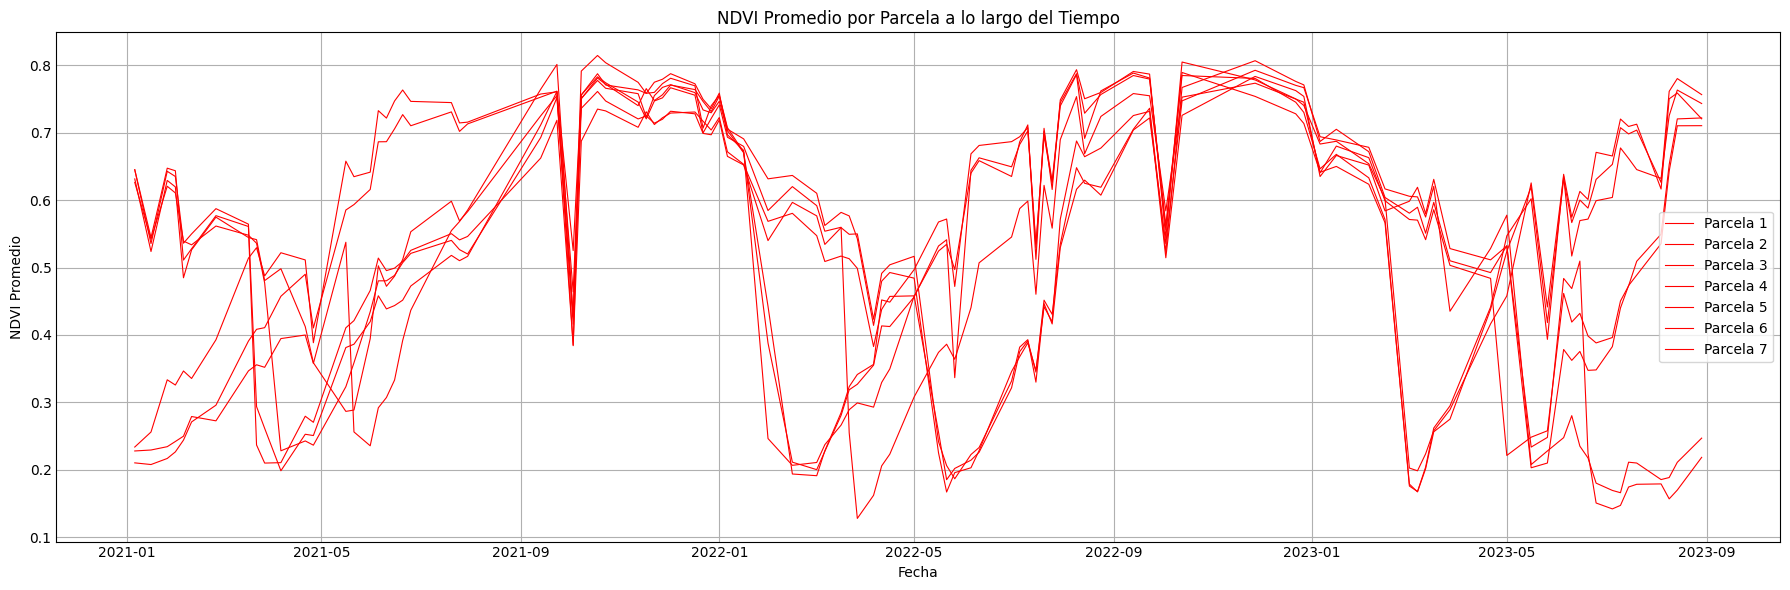

In [38]:
fig, ax = plt.subplots(figsize=(18, 6))

# Itera sobre cada parcela y grafica el NDVI promedio a lo largo del tiempo
for polygon_id in ndvi_df['Num_parcela'].unique():
    subset = ndvi_df[ndvi_df['Num_parcela'] == polygon_id]
    ax.plot(subset['Fecha'], subset['mean_ndvi'], label=f'Parcela {polygon_id}', linewidth=0.8, color='r')

# Etiqueta los ejes y el título del gráfico
ax.set_xlabel('Fecha')
ax.set_ylabel('NDVI Promedio')
ax.set_title('NDVI Promedio por Parcela a lo largo del Tiempo')

# Agrega una leyenda para identificar cada parcela en el gráfico
ax.legend()

# Muestra el gráfico
plt.tight_layout()
plt.show()